In [1]:
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon import nn
import numpy as np
import pickle as p
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
ctx = mx.gpu()
data_dir = '/home/sinyer/python/data/cifar10'

In [2]:
def load_cifar(route = data_dir+'/cifar-10-batches-py'):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    return train_pic, train_label, test_pic, test_label

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(test_data, net, ctx):
    acc = 0.
    for data, label in test_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc = acc + accuracy(output, label)
    return acc / len(test_data)

In [3]:
train_pic, train_label, test_pic, test_label = load_cifar()

batch_size = 128
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(
    train_pic.astype('float32')/255, train_label.astype('float32')), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(
    test_pic.astype('float32')/255, test_label.astype('float32')), batch_size, shuffle=False)

In [4]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128, activation="relu"),
        nn.Dense(10)
    )
net.initialize(ctx=ctx)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02, 'momentum': 0.9, 'wd': 5e-4})

0 loss:1.8597 tracc:0.3219 teacc:0.4565 time:18.192
10 loss:0.5632 tracc:0.8010 teacc:0.6735 time:1.861
20 loss:0.2029 tracc:0.9293 teacc:0.6563 time:1.865
30 loss:0.1151 tracc:0.9622 teacc:0.6613 time:1.868
40 loss:0.0228 tracc:0.9964 teacc:0.6872 time:1.865
50 loss:0.0079 tracc:1.0000 teacc:0.6937 time:1.870
60 loss:0.0095 tracc:1.0000 teacc:0.6928 time:1.869
70 loss:0.0099 tracc:1.0000 teacc:0.6932 time:1.874
tracc:1.000000 teacc:0.693532


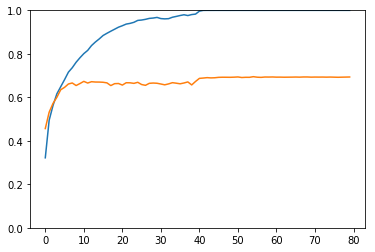

In [5]:
epochs = 80

a, b = [], []
for epoch in range(epochs):
    if epoch  == 40:
        trainer.set_learning_rate(0.005)
    if epoch  == 60:
        trainer.set_learning_rate(0.001)
    train_loss = 0.
    train_acc = 0.
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        trainer.step(batch_size)
        train_loss = train_loss + nd.mean(l).asscalar()
        train_acc = train_acc + accuracy(output, label)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    
    if epoch%10 == 0:
        print(epoch, 'loss:%.4f tracc:%.4f teacc:%.4f time:%.3f'%(
            train_loss/len(train_data), train_acc/len(train_data), test_acc, time()-start)) 
    a.append(train_acc/len(train_data))
    b.append(test_acc)

print('tracc:%f teacc:%f'%(train_acc/len(train_data), test_acc))
plt.plot(np.arange(epochs), a, np.arange(epochs), b)
plt.ylim(0,1)
plt.show()